In [1]:
import os
import glob
import datetime

import pandas as pd
import numpy as np
import re
import math

import matplotlib.pyplot as plt
import matplotlib.pylab as mpl
import matplotlib.gridspec as gridspec
import seaborn as sns

from IPython.display import display

from functools import partial
from scipy import signal

#from utils.SeabornFig2Grid import *
from utils.multi_processing_functions import *
#from utils.xcorr import correlate_maxlag, correlate_template, get_lags


In [2]:
os.getcwd()

'D:\\projects\\ErgoVR\\eye_hand_coordination\\Code'

In [3]:
sns.set(palette='muted', context='talk', style='ticks')
scpt = sns.color_palette()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

DATA_PATH = '../Data/'
PLOT_PATH = '../Plots/'

In [4]:
import multiprocessing as mp

def pandas_mp_apply(grouped_df, apply_func):
    with mp.Pool(mp.cpu_count() - 1) as p:
        ret_list = p.map(apply_func, [(group, name) for name, group in grouped_df])
    return pd.concat(ret_list)

# Presteps

In [5]:
objects_df = pd.read_csv(f'{DATA_PATH}02-1_objects.csv')

In [12]:
grasp_epochs_df = pd.read_csv(f'{DATA_PATH}02-5_grasp_epoch_body.csv')

grasp_epochs_df[['timestamp_dt','grasp_time', 'drop_time']] = grasp_epochs_df[[
    'timestamp_dt','grasp_time', 'drop_time']].apply(pd.to_datetime)

In [7]:
grasp_epochs_df.loc[
    grasp_epochs_df.is_fixation==False, 
    ['eye_local_theta_h', 'eye_local_theta_v']
] = np.nan


In [13]:
grasp_epochs_df.columns

Index(['subject_id', 'trial_num', 'trial_type', 'timestamp_dt', 'is_fixation',
       'hand_position_x', 'hand_position_y', 'hand_position_z',
       'nosePointer_position_x', 'nosePointer_position_y',
       'nosePointer_position_z', 'hand_local_theta_h', 'hand_local_theta_v',
       'eye_local_theta_h', 'eye_local_theta_v', 'eye_global_theta_h',
       'eye_global_theta_v', 'grasp_num', 'grasp_object', 'grasp_time',
       'drop_time', 'drop_location', 'pickup_location', 'sample_time',
       'time_bin'],
      dtype='object')

In [14]:
grp_cols = ['subject_id', 'trial_num', 'trial_type', 'pickup_location']
avg_fixations_pickup_df = (
    pandas_mp_apply(
        grasp_epochs_df.groupby(grp_cols),
        get_avg_fixations_body_pickup,
    )
)
# drop a trial with incomplete time bins (-1.25 is missing)
#avg_fixations_pickup_df.drop(avg_fixations_pickup_df.index[512:543], 0, inplace=True)
avg_fixations_pickup_df.head()

hand_local_theta_h  \
subject_id trial_num trial_type pickup_location time_bin                       
2006.0     2.0       hard       1_1             -1.8               16.742638   
                                                -1.6               19.337984   
                                                -1.4               20.998061   
                                                -1.2               21.453200   
                                                -1.0               20.927259   

                                                          hand_local_theta_v  \
subject_id trial_num trial_type pickup_location time_bin                       
2006.0     2.0       hard       1_1             -1.8               -2.709754   
                                                -1.6               -1.196991   
                                                -1.4               -1.128303   
                                                -1.2                2.510409   
                                                -1.0                6.792688   

                                                          eye_local_theta_h  \
subject_id trial_num trial_type pickup_location time_bin                      
2006.0     2.0       hard       1_1             -1.8               9.462453   
                                                -1.6              12.474980   
                                                -1.4              13.003206   
                                                -1.2              11.739528   
                                                -1.0              10.790280   

                                                          eye_local_theta_v  \
subject_id trial_num trial_type pickup_location time_bin                      
2006.0     2.0       hard       1_1             -1.8              12.645387   
                                                -1.6              11.132137   
                                                -1.4               8.611448   
                                                -1.2               7.363348   
                                                -1.0              10.058338   

                                                          eye_global_theta_h  \
subject_id trial_num trial_type pickup_location time_bin                       
2006.0     2.0       hard       1_1             -1.8               13.271409   
                                                -1.6               15.475417   
                                                -1.4               14.882823   
                                                -1.2               12.599328   
                                                -1.0                9.333037   

                                                          eye_global_theta_v  
subject_id trial_num trial_type pickup_location time_bin                      
2006.0     2.0       hard       1_1             -1.8                7.086444  
                                                -1.6                5.111262  
                                                -1.4                3.608404  
                                                -1.2                4.536624  
                                                -1.0               11.889784

In [65]:
normalized_df = avg_fixations_pickup_df.copy().reset_index()

normalized_df['hand_local_h_demean'] = (
    normalized_df
    .groupby(['subject_id', 'trial_num', 'trial_type', 'pickup_location',])
    .hand_local_theta_h
    .apply(lambda x: (x - x.mean()) / x.std())
    
)
normalized_df['hand_local_v_demean'] = (
    normalized_df
    .groupby(['subject_id', 'trial_num', 'trial_type', 'pickup_location', ])
    .hand_local_theta_v
    .apply(lambda x: (x - x.mean()) / x.std())
    
)
normalized_df['eye_local_h_demean'] = (
    normalized_df
    .groupby(['subject_id', 'trial_num', 'trial_type', 'pickup_location',])
    .eye_local_theta_h
    .apply(lambda x: (x - x.mean()) / x.std())
    
)
normalized_df['eye_local_v_demean'] = (
    normalized_df
    .groupby(['subject_id', 'trial_num', 'trial_type', 'pickup_location', ])
    .eye_local_theta_v
    .apply(lambda x: (x - x.mean()) / x.std())
    
)
normalized_df[['row', 'column']] = normalized_df.pickup_location.str.split('_', expand=True).astype(int)
normalized_df.head()

,subject_id,trial_num,trial_type,pickup_location,time_bin,hand_local_theta_h,hand_local_theta_v,eye_local_theta_h,eye_local_theta_v,eye_global_theta_h,eye_global_theta_v,hand_local_h_demean,hand_local_v_demean,eye_local_h_demean,eye_local_v_demean,row,column
0,2006.0,2.0,hard,1_1,-1.8,16.742638,-2.709754,9.462453,12.645387,13.271409,7.086444,0.426224,-0.258206,0.078079,0.875994,1,1
1,2006.0,2.0,hard,1_1,-1.6,19.337984,-1.196991,12.474980,11.132137,15.475417,5.111262,0.571585,-0.180527,0.608459,0.764558,1,1
2,2006.0,2.0,hard,1_1,-1.4,20.998061,-1.128303,13.003206,8.611448,14.882823,3.608404,0.664564,-0.177000,0.701457,0.578932,1,1
3,2006.0,2.0,hard,1_1,-1.2,21.453200,2.510409,11.739528,7.363348,12.599328,4.536624,0.690055,0.009843,0.478976,0.487021,1,1
4,2006.0,2.0,hard,1_1,-1.0,20.927259,6.792688,10.790280,10.058338,9.333037,11.889784,0.660598,0.229733,0.311854,0.685482,1,1


In [16]:
normalized_df.time_bin.nunique()

20

In [52]:
def xcorr_eye_hand(tmpdf):
    tmpdf =tmpdf.sort_values(by='time_bin')
    a = (
        tmpdf.eye_local_theta_h - np.mean(tmpdf.eye_local_theta_h)
    ) / (np.std(tmpdf.eye_local_theta_h) * len(tmpdf.eye_local_theta_h))
    b = (
        tmpdf.hand_local_theta_h - np.mean(tmpdf.hand_local_theta_h)
    ) / (np.std(tmpdf.hand_local_theta_h))
    
    xcorr_h = signal.correlate(a, b, 'full')
    
    a = (
        tmpdf.eye_local_theta_v - np.mean(tmpdf.eye_local_theta_v)
    ) / (np.std(tmpdf.eye_local_theta_v) * len(tmpdf.eye_local_theta_v))
    b = (
        tmpdf.hand_local_theta_v - np.mean(tmpdf.hand_local_theta_v)
    ) / (np.std(tmpdf.hand_local_theta_v))
    
    xcorr_v = signal.correlate(a, b, 'full')
    
    fisher_h = np.arctanh(xcorr_h)
    fisher_v = np.arctanh(xcorr_v)
    
    lag = np.linspace(-3.8, 3.8, 39)
    
    if xcorr_h.shape[0] != 39 or xcorr_v.shape[0] != 39:
        print(tmpdf.index)
        df = pd.DataFrame(
            {'lag': [], 'xcorr_h': [], 'xcorr_v': [], 'fisher_h': [], 'fisher_v': []}
        )
    else:
        
        df = pd.DataFrame(
            {'lag': lag, 'xcorr_h': xcorr_h, 'xcorr_v': 
             xcorr_v, 'fisher_h': fisher_h, 'fisher_v': fisher_v}
        )

    return df

xcorr_df = (
    avg_fixations_pickup_df
    .query('trial_type=="easy"')
    .groupby(['subject_id', 'trial_num', 'trial_type', 'pickup_location'])
    .apply(xcorr_eye_hand)
)

xcorr_df.head()

MultiIndex([(2012.0, 7.0, 'easy', '1_5',                   -1.8),
            (2012.0, 7.0, 'easy', '1_5',                   -1.6),
            (2012.0, 7.0, 'easy', '1_5',                   -1.4),
            (2012.0, 7.0, 'easy', '1_5',    -1.2000000000000002),
            (2012.0, 7.0, 'easy', '1_5',    -1.0000000000000002),
            (2012.0, 7.0, 'easy', '1_5',    -0.8000000000000003),
            (2012.0, 7.0, 'easy', '1_5',    -0.6000000000000003),
            (2012.0, 7.0, 'easy', '1_5',    -0.4000000000000004),
            (2012.0, 7.0, 'easy', '1_5',    -0.2000000000000004),
            (2012.0, 7.0, 'easy', '1_5', -4.440892098500626e-16),
            (2012.0, 7.0, 'easy', '1_5',     0.1999999999999995),
            (2012.0, 7.0, 'easy', '1_5',     0.3999999999999993),
            (2012.0, 7.0, 'easy', '1_5',     0.7999999999999996),
            (2012.0, 7.0, 'easy', '1_5',     0.9999999999999992),
            (2012.0, 7.0, 'easy', '1_5',      1.199999999999999),
          

MultiIndex([(2017.0, 16.0, 'easy', '1_1',                   -1.8),
            (2017.0, 16.0, 'easy', '1_1',                   -1.6),
            (2017.0, 16.0, 'easy', '1_1',                   -1.4),
            (2017.0, 16.0, 'easy', '1_1',    -1.2000000000000002),
            (2017.0, 16.0, 'easy', '1_1',    -1.0000000000000002),
            (2017.0, 16.0, 'easy', '1_1',    -0.8000000000000003),
            (2017.0, 16.0, 'easy', '1_1',    -0.6000000000000003),
            (2017.0, 16.0, 'easy', '1_1',    -0.4000000000000004),
            (2017.0, 16.0, 'easy', '1_1',    -0.2000000000000004),
            (2017.0, 16.0, 'easy', '1_1', -4.440892098500626e-16),
            (2017.0, 16.0, 'easy', '1_1',     0.1999999999999995),
            (2017.0, 16.0, 'easy', '1_1',     0.3999999999999993),
            (2017.0, 16.0, 'easy', '1_1',     0.7999999999999996),
            (2017.0, 16.0, 'easy', '1_1',     0.9999999999999992),
            (2017.0, 16.0, 'easy', '1_1',      1.1999999999999

MultiIndex([(2021.0, 22.0, 'easy', '4_3',                   -1.8),
            (2021.0, 22.0, 'easy', '4_3',                   -1.6),
            (2021.0, 22.0, 'easy', '4_3',                   -1.4),
            (2021.0, 22.0, 'easy', '4_3',    -1.2000000000000002),
            (2021.0, 22.0, 'easy', '4_3',    -1.0000000000000002),
            (2021.0, 22.0, 'easy', '4_3',    -0.8000000000000003),
            (2021.0, 22.0, 'easy', '4_3',    -0.6000000000000003),
            (2021.0, 22.0, 'easy', '4_3',    -0.4000000000000004),
            (2021.0, 22.0, 'easy', '4_3',    -0.2000000000000004),
            (2021.0, 22.0, 'easy', '4_3', -4.440892098500626e-16),
            (2021.0, 22.0, 'easy', '4_3',     0.1999999999999995),
            (2021.0, 22.0, 'easy', '4_3',     0.3999999999999993),
            (2021.0, 22.0, 'easy', '4_3',     0.5999999999999994),
            (2021.0, 22.0, 'easy', '4_3',     0.7999999999999996),
            (2021.0, 22.0, 'easy', '4_3',     0.99999999999999

lag   xcorr_h   xcorr_v  \
subject_id trial_num trial_type pickup_location                              
2006.0     3.0       easy       1_5             0 -3.8  0.006361  0.005440   
                                                1 -3.6 -0.003308  0.010877   
                                                2 -3.4 -0.023722 -0.015514   
                                                3 -3.2 -0.058210 -0.034298   
                                                4 -3.0 -0.012043 -0.015426   

                                                   fisher_h  fisher_v  
subject_id trial_num trial_type pickup_location                        
2006.0     3.0       easy       1_5             0  0.006361  0.005440  
                                                1 -0.003308  0.010878  
                                                2 -0.023727 -0.015515  
                                                3 -0.058276 -0.034311  
                                                4 -0.012044 -0.015428

In [18]:
grasp_epochs_df.reset_index().groupby('subject_id').trial_num.nunique()

subject_id
2006.0    22
2007.0     4
2009.0     4
2010.0    12
2012.0    18
2014.0    10
2015.0    21
2016.0    11
2017.0    20
2018.0    10
2019.0     4
2021.0    20
2025.0    12
2026.0    10
2027.0    21
2028.0    22
2029.0    15
2030.0    10
2031.0    14
2035.0    22
2043.0    22
2048.0    22
2049.0    22
2051.0    22
2052.0    21
2053.0    22
2059.0    20
Name: trial_num, dtype: int64

In [19]:
xcorr_df.reset_index().groupby('subject_id').trial_num.nunique()

subject_id
2006.0    14
2007.0     3
2009.0     2
2010.0     8
2012.0    12
2014.0     7
2015.0    14
2016.0     7
2017.0    14
2018.0     7
2019.0     3
2021.0    14
2025.0     8
2026.0     7
2027.0    14
2028.0    14
2029.0    15
2030.0     6
2031.0     7
2035.0    15
2043.0    14
2048.0    14
2049.0    14
2051.0    15
2052.0    15
2053.0    14
2059.0    13
Name: trial_num, dtype: int64

In [53]:
xcorr_df = xcorr_df.reset_index()

xcorr_df[['row', 'column']] = xcorr_df.pickup_location.str.split('_', expand=True).astype(int)

xcorr_df['lag'] = np.round(xcorr_df.lag, 1)

In [55]:
xcorr_df.head()

,subject_id,trial_num,trial_type,pickup_location,level_4,lag,xcorr_h,xcorr_v,fisher_h,fisher_v,row,column
0,2006.0,3.0,easy,1_5,0,-3.8,0.006361,0.005440,0.006361,0.005440,1,5
1,2006.0,3.0,easy,1_5,1,-3.6,-0.003308,0.010877,-0.003308,0.010878,1,5
2,2006.0,3.0,easy,1_5,2,-3.4,-0.023722,-0.015514,-0.023727,-0.015515,1,5
3,2006.0,3.0,easy,1_5,3,-3.2,-0.058210,-0.034298,-0.058276,-0.034311,1,5
4,2006.0,3.0,easy,1_5,4,-3.0,-0.012043,-0.015426,-0.012044,-0.015428,1,5


In [56]:
agg_row_ehc_strength = (
    xcorr_df
    .groupby(['subject_id', 'trial_num', 'row', 'lag'])
    .agg({
        'fisher_h':'mean',
        'fisher_v':'mean'
    })
    .reset_index()
    .groupby(['subject_id', 'trial_num', 'row'])
    .agg(
        max_corr_h = ('fisher_h', 'max'),
        min_corr_h = ('fisher_h', 'min'),
        #max_lag_h  = ('fisher_h', lambda x: x.idxmax()),
        #min_lag_h  = ('fisher_h', lambda x: x.idxmin()),
        max_corr_v = ('fisher_v', 'max'),
        min_corr_v = ('fisher_v', 'min'),
        #max_lag_v  = ('fisher_v', lambda x: x.idxmax()),
        #min_lag_v  = ('fisher_v', lambda x: x.idxmin()),
    )
)

agg_row_ehc_strength.head(10)

max_corr_h  min_corr_h  max_corr_v  min_corr_v
subject_id trial_num row                                                
2006.0     3.0       1      0.337743   -0.482962    0.514508   -0.371162
                     2      0.163970   -0.644425    0.430079   -0.626677
                     3      0.423485   -0.670081    0.361919   -0.594469
                     4      0.427166   -1.018069    0.291137   -0.355084
                     5      0.251800   -0.377134    0.406635   -0.278784
           5.0       1      0.614684   -0.637552    1.081420   -0.401352
                     2      0.135662   -0.208193    0.450669   -0.291048
                     3      0.515045   -0.383027    0.271865   -0.503780
                     4      0.537857   -0.289763    0.522493   -0.365552
                     5      0.245835   -0.133611    0.231770   -0.532406

In [84]:
agg_col_ehc_strength = (
    xcorr_df
    .groupby(['subject_id', 'trial_num', 'column', 'lag'])
    .agg({
        'fisher_h':'mean',
        'fisher_v':'mean'
    })
    .reset_index()
    .groupby(['subject_id', 'trial_num', 'column'])
    .agg(
        max_corr_h = ('fisher_h', 'max'),
        min_corr_h = ('fisher_h', 'min'),
        #max_lag_h  = ('fisher_h', lambda x: x.idxmax()),
        #min_lag_h  = ('fisher_h', lambda x: x.idxmin()),
        max_corr_v = ('fisher_v', 'max'),
        min_corr_v = ('fisher_v', 'min'),
        #max_lag_v  = ('fisher_v', lambda x: x.idxmax()),
        #min_lag_v  = ('fisher_v', lambda x: x.idxmin()),
    )
)

agg_col_ehc_strength.head(10)

max_corr_h  min_corr_h  max_corr_v  min_corr_v
subject_id trial_num column                                                
2006.0     3.0       1         0.321336   -0.592813    0.441436   -0.294341
                     2         0.496385   -0.685157    0.194038   -0.259634
                     4         0.315178   -0.468618    0.207710   -0.502847
                     5         0.273808   -0.261075    0.384434   -0.271632
           5.0       1         0.316632   -0.395033    0.193091   -0.338619
                     2         0.283152   -0.169564    0.244780   -0.285437
                     3         0.760480   -0.443742    0.393473   -0.430336
                     4         0.246727   -0.366282    0.452465   -0.266711
                     5         0.343216   -0.204724    0.340857   -0.513855
           6.0       1         0.273040   -0.274758    0.342895   -0.422642

In [58]:
agg_row_ehc_lag = (
    xcorr_df
    .groupby(['subject_id', 'trial_num', 'row', 'lag'])
    .agg({
        'fisher_h':'mean',
        'fisher_v':'mean'
    })
    .reset_index()
    .groupby(['subject_id', 'trial_num', 'row'])
    .apply(
        lambda x: pd.Series([
                x.loc[x['fisher_h'].idxmax(), 'lag'], 
                x.loc[x['fisher_v'].idxmax(), 'lag'],
                x.loc[x['fisher_h'].idxmin(), 'lag'], 
                x.loc[x['fisher_v'].idxmin(), 'lag'] 
            ])
    )
    .reset_index()
    .rename(columns={
        0: 'max_lag_h',
        1: 'max_lag_v',
        2: 'min_lag_h',
        3: 'min_lag_v'
    })
)

agg_row_ehc_lag.head(10)

,subject_id,trial_num,row,max_lag_h,max_lag_v,min_lag_h,min_lag_v
0,2006.0,3.0,1,1.6,1.8,3.6,2.8
1,2006.0,3.0,2,-2.0,2.2,0.0,1.0
2,2006.0,3.0,3,2.0,1.8,0.0,1.0
3,2006.0,3.0,4,2.4,-0.8,0.0,2.2
4,2006.0,3.0,5,-2.6,-0.8,-1.8,-2.8
5,2006.0,5.0,1,-0.8,-0.2,0.0,-3.0
6,2006.0,5.0,2,-0.2,-0.2,0.6,2.2
7,2006.0,5.0,3,-0.6,-2.2,0.0,0.0
8,2006.0,5.0,4,-0.2,-0.6,0.8,0.0
9,2006.0,5.0,5,0.6,-1.2,1.4,0.0


In [88]:
df1 = pd.melt(
    agg_row_ehc_strength.reset_index(), 
    id_vars=['subject_id', 'trial_num', 'row'], 
    value_vars=['max_corr_h', 'max_corr_v'],
    var_name='rot_plane', value_name='max_corr'
)
df1.rot_plane = df1.rot_plane.map({'max_corr_h':'horizontal', 'max_corr_v':'vertical'})

df2 = pd.melt(
    agg_row_ehc_strength.reset_index(), 
    id_vars=['subject_id', 'trial_num', 'row'], 
    value_vars=['min_corr_h', 'min_corr_v'],
    var_name='rot_plane', value_name='min_corr'
)
df2.rot_plane = df2.rot_plane.map({'min_corr_h':'horizontal', 'min_corr_v':'vertical'})

tmpdf = df1.merge(df2, on=['subject_id', 'trial_num', 'row', 'rot_plane'])

df1 = pd.melt(
    agg_row_ehc_lag, 
    id_vars=['subject_id', 'trial_num', 'row'], 
    value_vars=['max_lag_h', 'max_lag_v'],
    var_name='rot_plane', value_name='max_lag'
)
df1.rot_plane = df1.rot_plane.map({'max_lag_h':'horizontal', 'max_lag_v':'vertical'})

df2 = pd.melt(
    agg_row_ehc_lag, 
    id_vars=['subject_id', 'trial_num', 'row'], 
    value_vars=['min_lag_h', 'min_lag_v'],
    var_name='rot_plane', value_name='min_lag'
)
df2.rot_plane = df2.rot_plane.map({'min_lag_h':'horizontal', 'min_lag_v':'vertical'})

tmpdf = (
    tmpdf
    .merge(df1, on=['subject_id', 'trial_num', 'row', 'rot_plane'])
    .merge(df2, on=['subject_id', 'trial_num', 'row', 'rot_plane'])
)
tmpdf.to_csv('row_ehc.csv',)

In [59]:
agg_col_ehc_lag = (
    xcorr_df
    .groupby(['subject_id', 'trial_num', 'column', 'lag'])
    .agg({
        'fisher_h':'mean',
        'fisher_v':'mean'
    })
    .reset_index()
    .groupby(['subject_id', 'trial_num', 'column'])
    .apply(
        lambda x: pd.Series([
                x.loc[x['fisher_h'].idxmax(), 'lag'], 
                x.loc[x['fisher_v'].idxmax(), 'lag'],
                x.loc[x['fisher_h'].idxmin(), 'lag'], 
                x.loc[x['fisher_v'].idxmin(), 'lag'] 
            ])
    )
    .reset_index()
    .rename(columns={
        0: 'max_lag_h',
        1: 'max_lag_v',
        2: 'min_lag_h',
        3: 'min_lag_v'
    })
)

agg_col_ehc_lag.head(10)

,subject_id,trial_num,column,max_lag_h,max_lag_v,min_lag_h,min_lag_v
0,2006.0,3.0,1,-2.4,2.0,0.0,1.0
1,2006.0,3.0,2,2.0,-3.4,0.0,-1.4
2,2006.0,3.0,4,-0.8,1.8,0.0,0.8
3,2006.0,3.0,5,0.0,1.8,3.6,2.8
4,2006.0,5.0,1,-1.4,-0.6,0.6,0.0
5,2006.0,5.0,2,-0.2,-1.0,2.6,0.0
6,2006.0,5.0,3,0.0,-0.4,1.4,-1.8
7,2006.0,5.0,4,1.4,-0.2,0.0,1.2
8,2006.0,5.0,5,-0.8,1.2,1.6,0.0
9,2006.0,6.0,1,0.2,1.4,1.0,0.0


In [89]:
df1 = pd.melt(
    agg_col_ehc_strength.reset_index(), 
    id_vars=['subject_id', 'trial_num', 'column'], 
    value_vars=['max_corr_h', 'max_corr_v'],
    var_name='rot_plane', value_name='max_corr'
)
df1.rot_plane = df1.rot_plane.map({'max_corr_h':'horizontal', 'max_corr_v':'vertical'})

df2 = pd.melt(
    agg_col_ehc_strength.reset_index(), 
    id_vars=['subject_id', 'trial_num', 'column'], 
    value_vars=['min_corr_h', 'min_corr_v'],
    var_name='rot_plane', value_name='min_corr'
)
df2.rot_plane = df2.rot_plane.map({'min_corr_h':'horizontal', 'min_corr_v':'vertical'})

tmpdf = df1.merge(df2, on=['subject_id', 'trial_num', 'column', 'rot_plane'])

df1 = pd.melt(
    agg_col_ehc_lag, 
    id_vars=['subject_id', 'trial_num', 'column'], 
    value_vars=['max_lag_h', 'max_lag_v'],
    var_name='rot_plane', value_name='max_lag'
)
df1.rot_plane = df1.rot_plane.map({'max_lag_h':'horizontal', 'max_lag_v':'vertical'})

df2 = pd.melt(
    agg_col_ehc_lag, 
    id_vars=['subject_id', 'trial_num', 'column'], 
    value_vars=['min_lag_h', 'min_lag_v'],
    var_name='rot_plane', value_name='min_lag'
)
df2.rot_plane = df2.rot_plane.map({'min_lag_h':'horizontal', 'min_lag_v':'vertical'})

tmpdf = (
    tmpdf
    .merge(df1, on=['subject_id', 'trial_num', 'column', 'rot_plane'])
    .merge(df2, on=['subject_id', 'trial_num', 'column', 'rot_plane'])
)
tmpdf.to_csv('col_ehc.csv',)

# PLOTS

## Normalized Angular deviations

In [ ]:
sns.color_palette('coolwarm', 17)

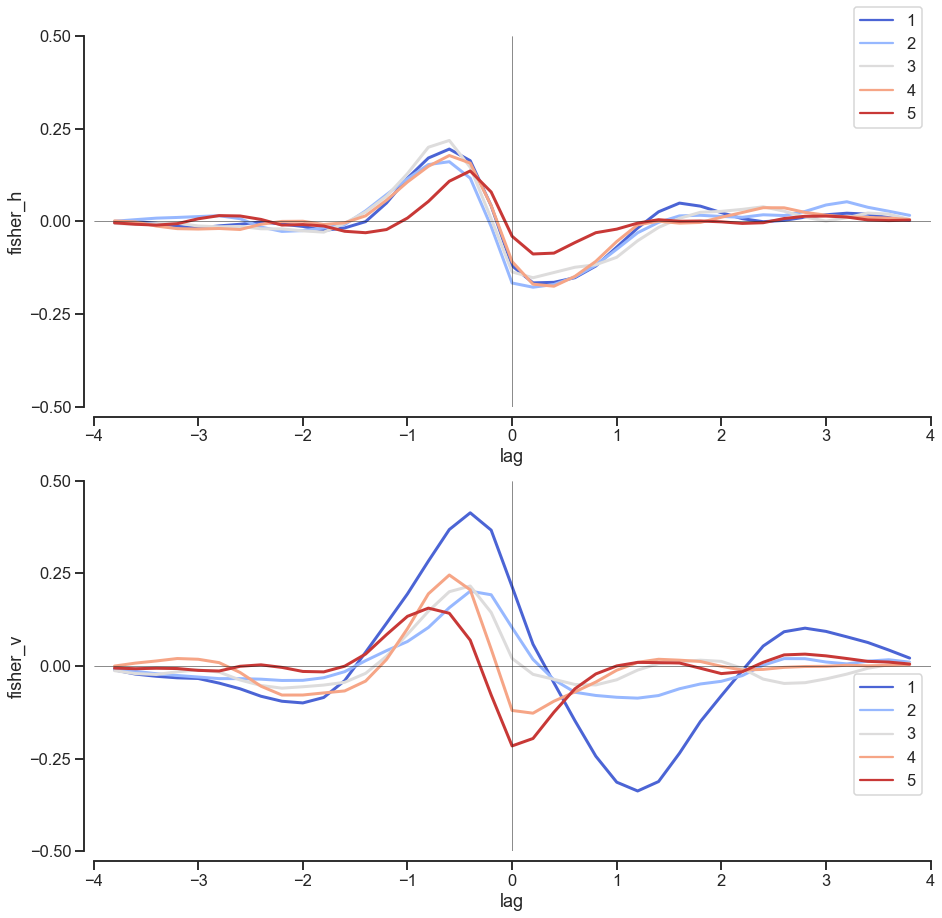

In [60]:
fig, ax = plt.subplots(2, 1, figsize=(15, 15), sharey=True)

xcorr_df[['row', 'column']] = xcorr_df.pickup_location.str.split('_', expand=True).astype(int)
tmpdf = (
    xcorr_df
    .query('trial_type=="easy"')
    .groupby(['subject_id', 'trial_num', 'row', 'lag'])
    .agg({
        'fisher_h':'mean',
        'fisher_v':'mean'
    })
    .reset_index()
    .groupby(['subject_id', 'row', 'lag'])
    .agg({
        'fisher_h':'mean',
        'fisher_v':'mean'
    })
    .reset_index()
)
sns.lineplot(x=tmpdf.lag, y=tmpdf.fisher_h,
             hue=tmpdf.row,
             ci=None,
             hue_order=[1, 2, 3, 4, 5],
             #ls='--', 
             lw=3,
             palette=sns.color_palette('coolwarm', 17)[0::4],
             ax=ax[0]
             
)

sns.lineplot(x=tmpdf.lag, y=tmpdf.fisher_v,
             hue=tmpdf.row,
             ci=None,
             hue_order=[1, 2, 3, 4, 5],
             lw=3,
             palette=sns.color_palette('coolwarm', 17)[0::4],
             ax=ax[1]
             
)

ax[0].axvline(0, color='k', lw=0.5)
ax[0].axhline(0, color='k', lw=0.5)

ax[1].axvline(0, color='k', lw=0.5)
ax[1].axhline(0, color='k', lw=0.5)

ax[0].legend(bbox_to_anchor=[1, 1.1])
ax[1].legend(bbox_to_anchor=[1, 0.5])

ax[0].set(
    ylim=(-0.5, 0.5),
    xlim=(-4, 4),
    yticks=np.arange(-0.5, 0.6, 0.25)
)
ax[1].set(
    xlim=(-4,4)
)

sns.despine(offset=10)
plt.savefig(f'{PLOT_PATH}/xcorr_rows.pdf', transparent=True, quality=90, bbox_inches='tight')

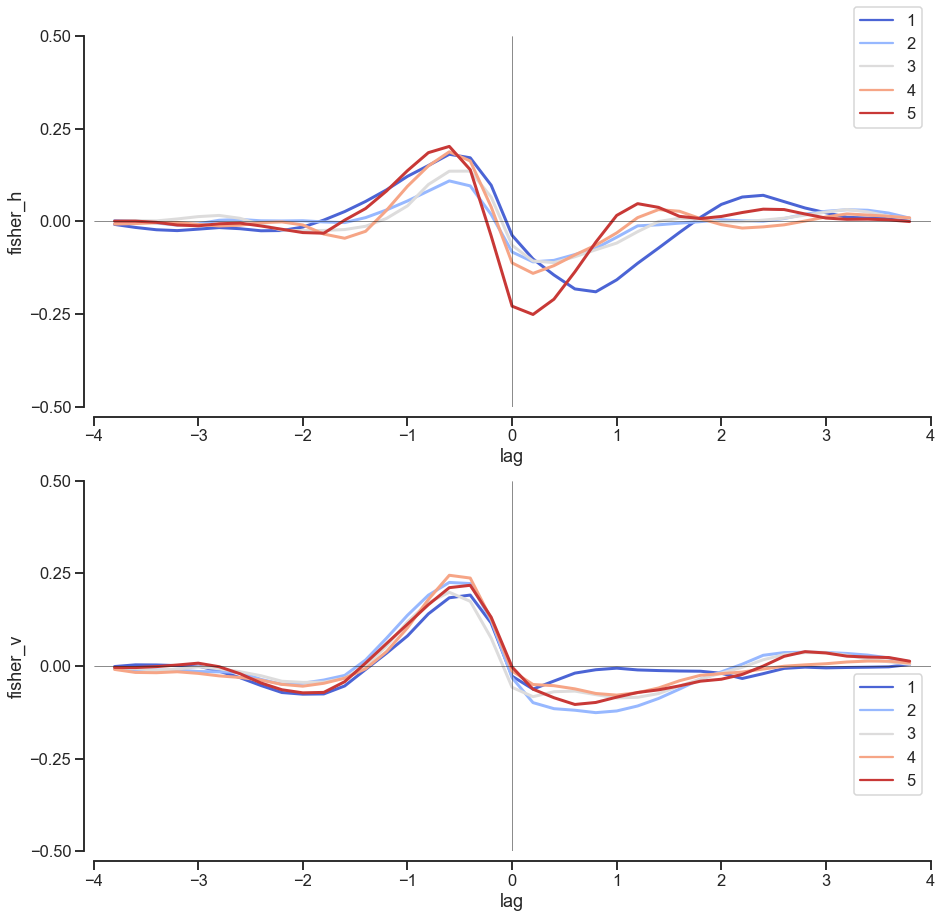

In [61]:
fig, ax = plt.subplots(2, 1, figsize=(15, 15), sharey=True)

tmpdf = (
    xcorr_df
    .query('trial_type=="easy"')
    .groupby(['subject_id', 'trial_num', 'column', 'lag'])
    .agg({
        'fisher_h':'mean',
        'fisher_v':'mean'
    })
    .reset_index()
    .groupby(['subject_id', 'column', 'lag'])
    .agg({
        'fisher_h':'mean',
        'fisher_v':'mean'
    })
    .reset_index()
)
sns.lineplot(x=tmpdf.lag, y=tmpdf.fisher_h,
             hue=tmpdf.column,
             ci=None,
             hue_order=[1, 2, 3, 4, 5],
             #ls='--', 
             lw=3,
             palette=sns.color_palette('coolwarm', 17)[0::4],
             ax=ax[0]
             
)

sns.lineplot(x=tmpdf.lag, y=tmpdf.fisher_v,
             hue=tmpdf.column,
             ci=None,
             hue_order=[1, 2, 3, 4, 5],
             lw=3,
             palette=sns.color_palette('coolwarm', 17)[0::4],
             ax=ax[1]
             
)
ax[0].axvline(0, color='k', lw=0.5)
ax[0].axhline(0, color='k', lw=0.5)

ax[1].axvline(0, color='k', lw=0.5)
ax[1].axhline(0, color='k', lw=0.5)

ax[0].legend(bbox_to_anchor=[1, 1.1])
ax[1].legend(bbox_to_anchor=[1, 0.5])

ax[0].set(
    ylim=(-0.5, 0.5),
    xlim=(-4, 4),
    yticks=np.arange(-0.5, 0.6, 0.25)
)
ax[1].set(
    xlim=(-4,4)
)

sns.despine(offset=10)

plt.savefig(f'{PLOT_PATH}/xcorr_columns.pdf', transparent=True, quality=90, bbox_inches='tight')

# Time course
## General

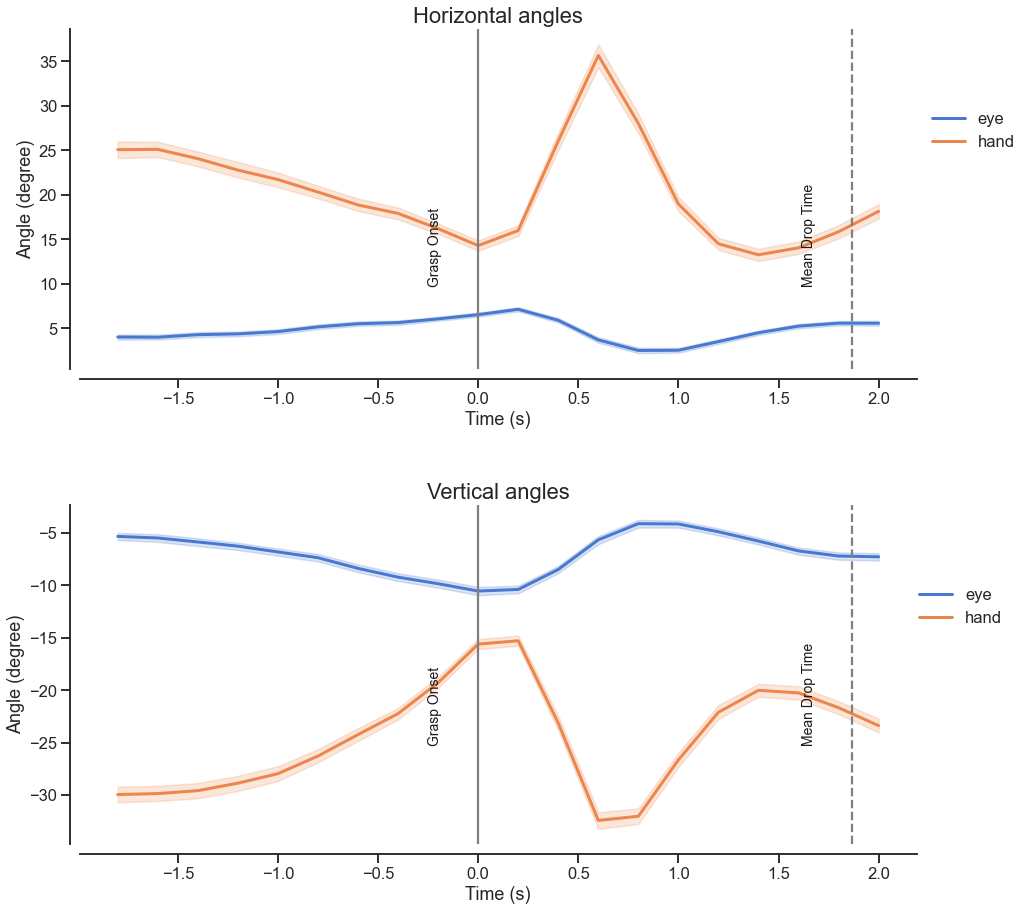

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(15, 15))
ax = ax.ravel()
tmpdf = (
    avg_fixations_pickup_df
    .reset_index()
)

# ax0
sns.lineplot(
    x=tmpdf.time_bin, y=tmpdf.eye_local_theta_h, 
    ax=ax[0],
    label='eye',
    color=scpt[0], ci=95,
    linewidth=3,
)

sns.lineplot(
    x=tmpdf.time_bin, y=tmpdf.hand_local_theta_h, 
    ax=ax[0], 
    label='hand',
    color=scpt[1], ci=95,
    linewidth=3,
)

# ax1
sns.lineplot(
    x=tmpdf.time_bin, y=tmpdf.eye_local_theta_v, 
    ax=ax[1],
    label='eye',
    color=scpt[0], ci=95,
    linewidth=3,
)

sns.lineplot(
    x=tmpdf.time_bin, y=tmpdf.hand_local_theta_v, 
    ax=ax[1], 
    label='hand',
    color=scpt[1], ci=95,
    linewidth=3,
)


ax[0].axvline(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).mean() / np.timedelta64(1, 's'),
    color='grey', ls='--',
)
ax[0].text(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).mean() 
    / np.timedelta64(1, 's') - 0.25,
    10, 'Mean Drop Time', {'color': 'k', 'fontsize': 14}, rotation=90,
)
ax[0].text(-0.25, 10, 'Grasp Onset', {'color': 'k', 'fontsize': 14}, rotation=90,)
ax[0].axvline(0, color='grey', ls='-')
ax[1].axvline(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).mean() / np.timedelta64(1, 's'),
    color='grey', ls='--',
)
ax[1].text(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).mean() 
    / np.timedelta64(1, 's') - 0.25,
    -25, 'Mean Drop Time', {'color': 'k', 'fontsize': 14}, rotation=90,
)
ax[1].text(-0.25, -25, 'Grasp Onset', {'color': 'k', 'fontsize': 14}, rotation=90,)
ax[1].axvline(0, color='grey', ls='-')

ax[0].set_ylabel('Angle (degree)')
ax[0].set_xlabel('Time (s)')
ax[1].set_ylabel('Angle (degree)')
ax[1].set_xlabel('Time (s)')

ax[0].set_title('Horizontal angles', fontsize=22)
ax[0].legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax[1].set_title('Vertical angles', fontsize=22)
ax[1].legend(frameon=False, bbox_to_anchor=(1.12, 0.8))

sns.despine(offset=10)
plt.subplots_adjust(hspace=0.4)
del tmpdf

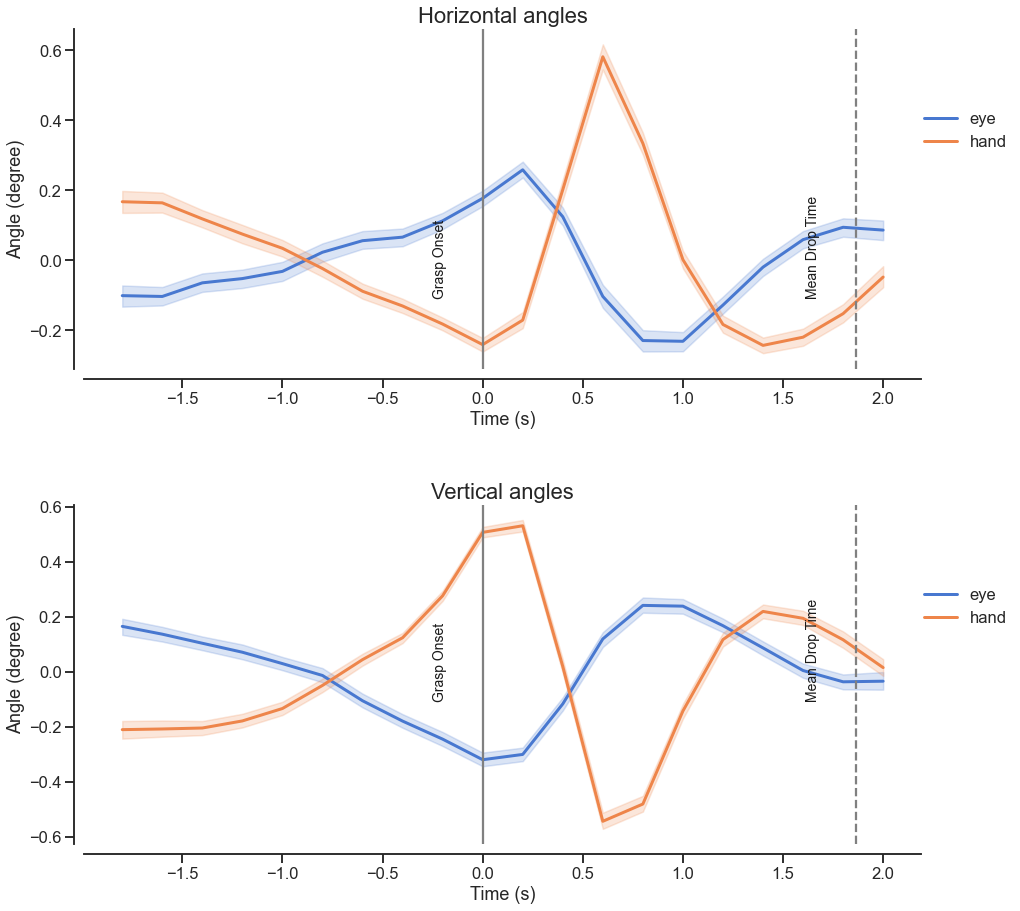

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(15, 15))
ax = ax.ravel()
tmpdf = (
    normalized_df
    .reset_index()
)

# ax0
sns.lineplot(
    x=tmpdf.time_bin, y=tmpdf.eye_local_h_demean, 
    ax=ax[0],
    label='eye',
    color=scpt[0], ci=95,
    linewidth=3,
)

sns.lineplot(
    x=tmpdf.time_bin, y=tmpdf.hand_local_h_demean, 
    ax=ax[0], 
    label='hand',
    color=scpt[1], ci=95,
    linewidth=3,
)

# ax1
sns.lineplot(
    x=tmpdf.time_bin, y=tmpdf.eye_local_v_demean, 
    ax=ax[1],
    label='eye',
    color=scpt[0], ci=95,
    linewidth=3,
)

sns.lineplot(
    x=tmpdf.time_bin, y=tmpdf.hand_local_v_demean, 
    ax=ax[1], 
    label='hand',
    color=scpt[1], ci=95,
    linewidth=3,
)


ax[0].axvline(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).mean() / np.timedelta64(1, 's'),
    color='grey', ls='--',
)
ax[0].text(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).mean() 
    / np.timedelta64(1, 's') - 0.25,
    -0.1, 'Mean Drop Time', {'color': 'k', 'fontsize': 14}, rotation=90,
)
ax[0].text(-0.25, -0.1, 'Grasp Onset', {'color': 'k', 'fontsize': 14}, rotation=90,)
ax[0].axvline(0, color='grey', ls='-')
ax[1].axvline(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).mean() / np.timedelta64(1, 's'),
    color='grey', ls='--',
)
ax[1].text(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).mean() 
    / np.timedelta64(1, 's') - 0.25,
    -0.1, 'Mean Drop Time', {'color': 'k', 'fontsize': 14}, rotation=90,
)
ax[1].text(-0.25, -0.1, 'Grasp Onset', {'color': 'k', 'fontsize': 14}, rotation=90,)
ax[1].axvline(0, color='grey', ls='-')

ax[0].set_ylabel('Angle (degree)')
ax[0].set_xlabel('Time (s)')
ax[1].set_ylabel('Angle (degree)')
ax[1].set_xlabel('Time (s)')

ax[0].set_title('Horizontal angles', fontsize=22)
ax[0].legend(frameon=False, bbox_to_anchor=(1.12, 0.8))
ax[1].set_title('Vertical angles', fontsize=22)
ax[1].legend(frameon=False, bbox_to_anchor=(1.12, 0.8))

sns.despine(offset=10)
plt.subplots_adjust(hspace=0.4)
del tmpdf

## Horizontal

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitl

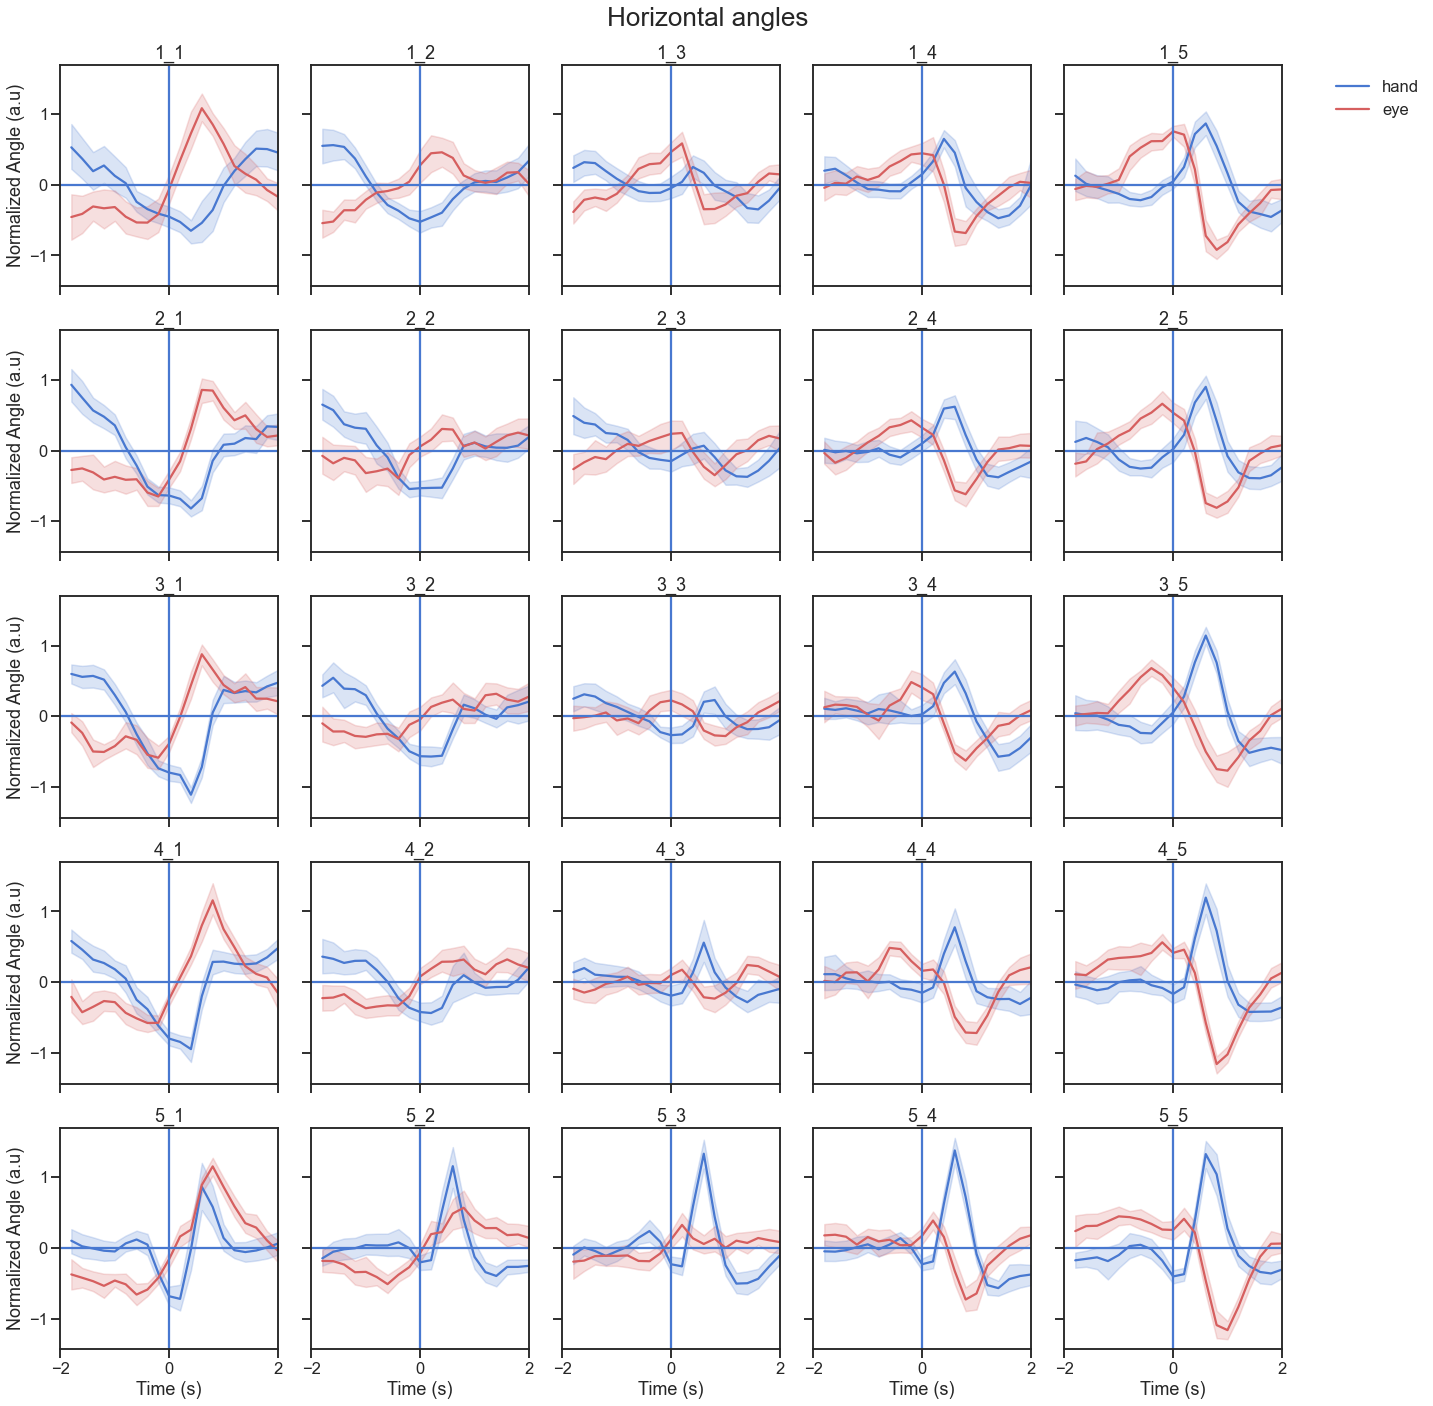

In [69]:
shelves = np.sort(normalized_df.pickup_location.unique())
n = 5
m = math.ceil(len(shelves)/n)

fig, ax = plt.subplots(n, m, figsize=(20, n*4), sharex=True, sharey=True)


for i, shelf in enumerate(shelves):
    tmpdf = (
        normalized_df
        #.query('trial_type=="easy"')
        .query('pickup_location == @shelf')
        .groupby(['subject_id', 'time_bin'])
        ['eye_local_h_demean', 'hand_local_h_demean']
        .mean()  
        .reset_index()
    )
    
    sns.lineplot(
        x=tmpdf.time_bin, 
        y=tmpdf.hand_local_h_demean,
        ax=ax[int(i/n)][i%n],
        label='hand',
        color='b', ci=95,
        legend=False
    )
    
    sns.lineplot(
        x=tmpdf.time_bin, 
        y=tmpdf.eye_local_h_demean,  
        ax=ax[int(i/n)][i%n],
        label='eye',
        color='r', ci=95,
        legend=False
    )
    ax[int(i/n)][i%n].axhline(0)
    ax[int(i/n)][i%n].axvline(0)
    #ax[int(i/n)][i%n].set_title(str(shelf), fontsize=18)
    #ax[int(i/n)][i%n].set_ylabel('Angle (degree)')
    #ax[int(i/n)][i%n].set_xlabel('Time (s)')
    
    ax[int(i/n)][i%n].set(
        title=str(shelf),
        ylabel='Normalized Angle (a.u)',
        xlabel='Time (s)',
        xticks=[-2,0,2],
        xlim=(-2,2)
    )

ax[0][4].legend(frameon=False, bbox_to_anchor=(1.7, 1))
fig.suptitle('Horizontal angles', fontsize=26)
fig.tight_layout()

plt.subplots_adjust(hspace=0.2, top=0.94)

plt.savefig(f'{PLOT_PATH}/normalized_angles_h.pdf', transparent=True, quality=90, bbox_inches='tight')


C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitl

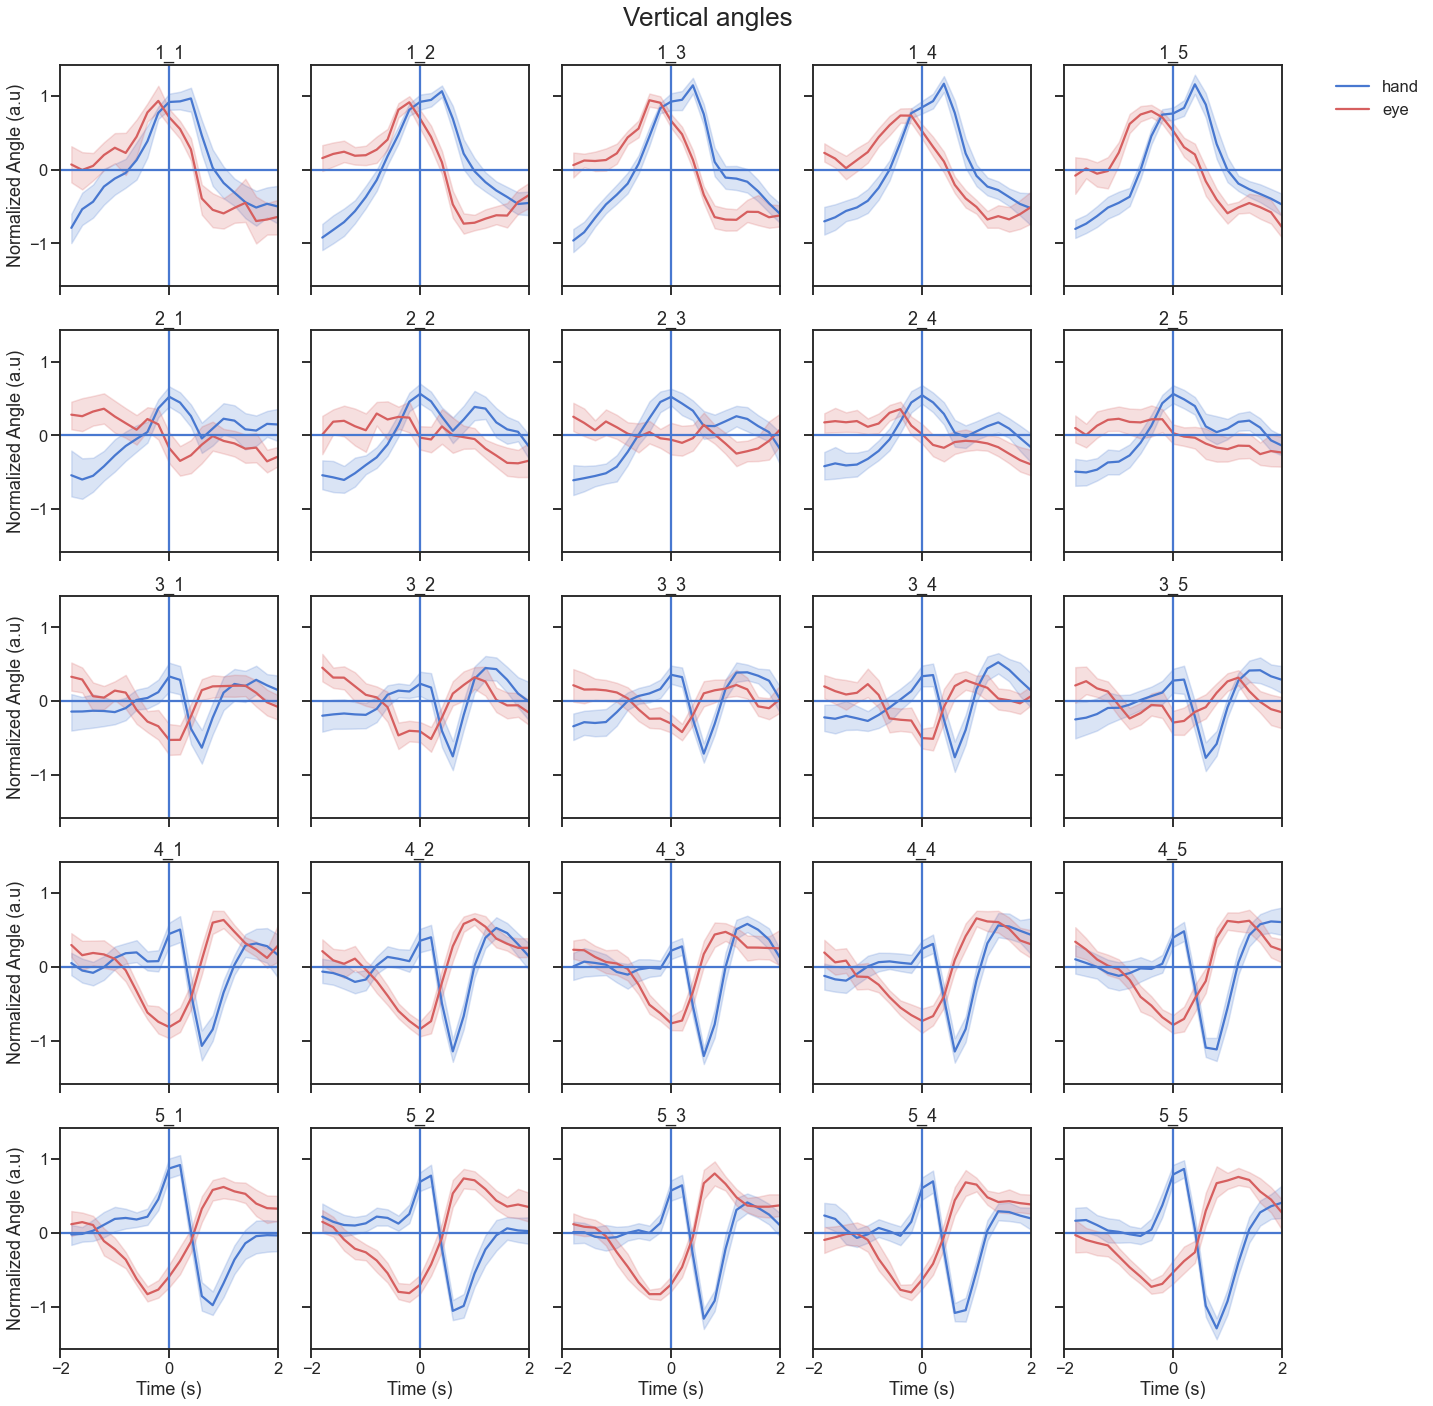

In [70]:
shelves = np.sort(normalized_df.pickup_location.unique())
n = 5
m = math.ceil(len(shelves)/n)

fig, ax = plt.subplots(n, m, figsize=(20, n*4), sharex=True, sharey=True)


for i, shelf in enumerate(shelves):
    tmpdf = (
        normalized_df
        #.query('trial_type=="easy"')
        .query('pickup_location == @shelf')
        .groupby(['subject_id', 'time_bin'])
        ['eye_local_v_demean', 'hand_local_v_demean']
        .mean()  
        .reset_index()
    )
    
    sns.lineplot(
        x=tmpdf.time_bin, 
        y=tmpdf.hand_local_v_demean,
        ax=ax[int(i/n)][i%n],
        label='hand',
        color='b', ci=95,
        legend=False
    )
    
    sns.lineplot(
        x=tmpdf.time_bin, 
        y=tmpdf.eye_local_v_demean,  
        ax=ax[int(i/n)][i%n],
        label='eye',
        color='r', ci=95,
        legend=False
    )
    ax[int(i/n)][i%n].axhline(0)
    ax[int(i/n)][i%n].axvline(0)
    #ax[int(i/n)][i%n].set_title(str(shelf), fontsize=18)
    #ax[int(i/n)][i%n].set_ylabel('Angle (degree)')
    #ax[int(i/n)][i%n].set_xlabel('Time (s)')
    
    ax[int(i/n)][i%n].set(
        title=str(shelf),
        ylabel='Normalized Angle (a.u)',
        xlabel='Time (s)',
        xticks=[-2,0,2],
        xlim=(-2,2)
    )

ax[0][4].legend(frameon=False, bbox_to_anchor=(1.7, 1))
fig.suptitle('Vertical angles', fontsize=26)
fig.tight_layout()

plt.subplots_adjust(hspace=0.2, top=0.94)

plt.savefig(f'{PLOT_PATH}/normalized_angles_v.pdf', transparent=True, quality=90, bbox_inches='tight')


In [76]:
avg_fixations_pickup_df.columns

Index(['subject_id', 'trial_num', 'trial_type', 'pickup_location', 'time_bin',
       'hand_local_theta_h', 'hand_local_theta_v', 'eye_local_theta_h',
       'eye_local_theta_v', 'eye_global_theta_h', 'eye_global_theta_v'],
      dtype='object')

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.

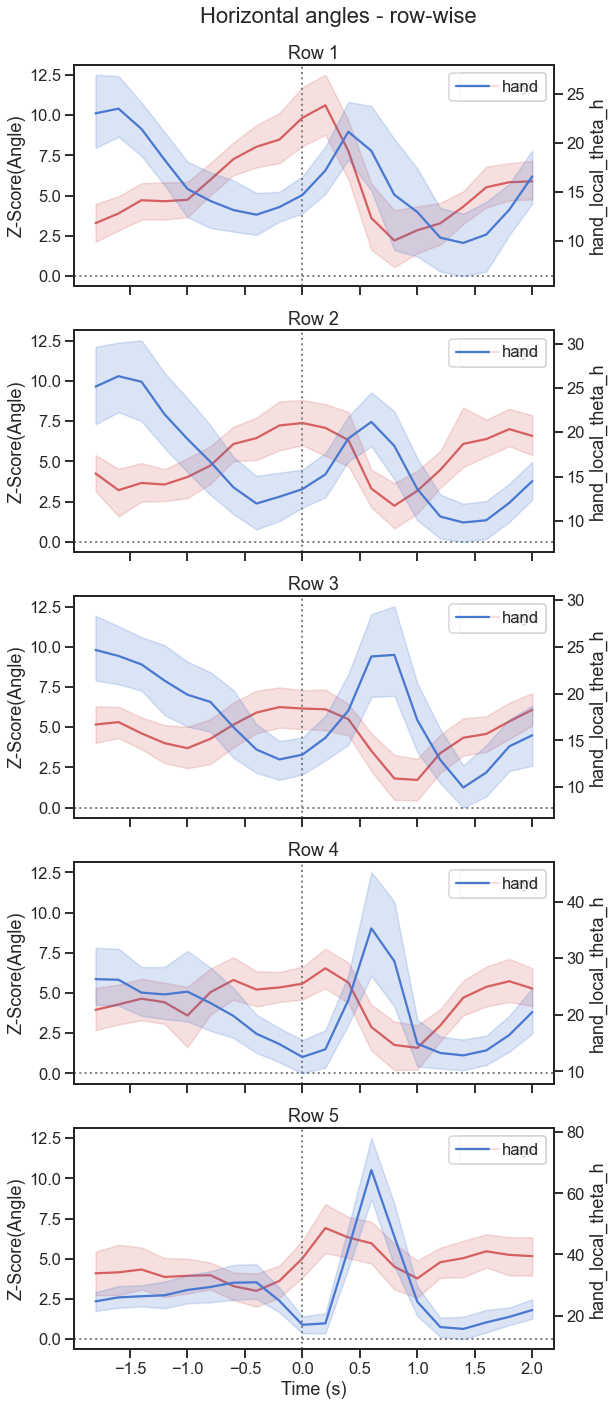

In [81]:
# rows
n = 5
fig, ax = plt.subplots(n, 1, figsize=(8, 20), sharex=True, sharey=True)
#scpt = sns.color_palette('coolwarm', 7)

#avg_fixations_pickup_df = avg_fixations_pickup_df.reset_index()
for i in range(n):
    tmpdf = (
        avg_fixations_pickup_df
        .query('trial_type=="easy"')
        .loc[avg_fixations_pickup_df['pickup_location'].str.startswith(str(i+1))]
        .groupby(['subject_id', 'time_bin'])
        ['eye_local_theta_h', 'hand_local_theta_h']
        .mean() 
        .reset_index()
    )
    
    ax1 = ax[i].twinx()
    sns.lineplot(
        x=tmpdf.time_bin, 
        y=tmpdf.eye_local_theta_h,
        ax=ax[i],
        label='eye',
        color='r', 
        ci=95,
        #legend=False
    )
    
    sns.lineplot(
        x=tmpdf.time_bin, 
        y=tmpdf.hand_local_theta_h,  
        ax=ax1,
        label='hand',
        color='b', 
        ci=95,
        #legend=False
    )
    
    ax[i].set_title('Row ' + str(i+1), fontsize=18)
    ax[i].set_ylabel('Z-Score(Angle)')
    ax[i].set_xlabel('Time (s)')
    #ax[i].set_ylim(-5, 5)
    #ax1.set_ylim(-20, 40)
    ax[i].axhline(y=0, color='gray', linestyle=':', linewidth=2)
    ax[i].axvline(x=0, color='gray', linestyle=':', linewidth=2)

#ax[0].legend(frameon=False, bbox_to_anchor=(1, 1))
#sns.despine(offset=10)
fig.suptitle('Horizontal angles - row-wise', fontsize=22)
fig.tight_layout()

plt.subplots_adjust(hspace=0.2, top=0.94, left=0.04)

plt.savefig(f'{PLOT_PATH}/angles_row_h.pdf', transparent=True, quality=90, bbox_inches='tight')


In [ ]:
# columns
n = 5
fig, ax = plt.subplots(n, 1, figsize=(8, 20), sharex=True, sharey=True)

for i in range(n):
    tmpdf = (
        normalized_df
        .query('trial_type == "easy"')
        .loc[normalized_df['pickup_location'].str.endswith(str(i+1))]
        .groupby(['subject_id', 'time_bin'])
        ['eye_local_h_demean', 'hand_local_h_demean']
        .mean() 
        .reset_index()
    )
    
    sns.lineplot(
        x=tmpdf.time_bin, 
        y=tmpdf.hand_local_h_demean,
        ax=ax[i],
        label='hand',
        color=scpt[0], ci=95,
        #legend=False
    )
    
    sns.lineplot(
        x=tmpdf.time_bin, 
        y=tmpdf.eye_local_h_demean,  
        ax=ax[i],
        label='eye',
        color=scpt[1], ci=95,
        #legend=False
    )
    
    ax[i].set_title('Column ' + str(i+1), fontsize=18)
    ax[i].set_ylabel('Angle (degree)')
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylim(-1.2, 1.2)
    ax[i].axhline(y=0, color='gray', linestyle=':', linewidth=2)
    ax[i].axvline(x=0, color='gray', linestyle=':', linewidth=2)

#ax[0].legend(frameon=False, bbox_to_anchor=(1, 1))
fig.suptitle('Horizontal angles - column-wise', fontsize=22)
fig.tight_layout()

plt.subplots_adjust(hspace=0.2, top=0.94, left=0.04)
del tmpdf

## Vertical

In [ ]:
shelves = np.sort(normalized_df.pickup_location.unique())
n = 5
m = math.ceil(len(shelves)/n)

fig, ax = plt.subplots(n, m, figsize=(20, n*4), sharex=True, sharey=True)


for i, shelf in enumerate(shelves):
    tmpdf = (
        normalized_df
        .query('trial_type=="easy"')
        .query('pickup_location == @shelf')
        .groupby(['subject_id', 'time_bin'])
        ['eye_local_v_demean', 'hand_local_v_demean']
        .mean()  
        .reset_index()
    )
    
    sns.lineplot(
        x=tmpdf.time_bin, 
        y=tmpdf.hand_local_v_demean,
        ax=ax[int(i/n)][i%n],
        label='hand',
        color=scpt[0], ci=95,
        legend=False
    )
    
    sns.lineplot(
        x=tmpdf.time_bin, 
        y=tmpdf.eye_local_v_demean,  
        ax=ax[int(i/n)][i%n],
        label='eye',
        color=scpt[1], ci=95,
        legend=False
    )
    
    ax[int(i/n)][i%n].set_title(str(shelf), fontsize=18)
    ax[int(i/n)][i%n].set_ylabel('Angle (degree)')
    ax[int(i/n)][i%n].set_xlabel('Time (s)')

ax[0][4].legend(frameon=False, bbox_to_anchor=(1.7, 1))
fig.suptitle('Vertical angles', fontsize=26)
fig.tight_layout()

plt.subplots_adjust(hspace=0.2, top=0.94)
del tmpdf  

In [ ]:
# rows
n = 5
fig, ax = plt.subplots(n, 1, figsize=(8, 20), sharex=True, sharey=True)

for i in range(n):
    tmpdf = (
        normalized_df
        .query('trial_type=="easy"')
        .loc[normalized_df['pickup_location'].str.startswith(str(i+1))]
        .groupby(['subject_id', 'time_bin'])
        ['eye_local_v_demean', 'hand_local_v_demean']
        .mean() 
        .reset_index()
    )
    
    sns.lineplot(
        x=tmpdf.time_bin, 
        y=tmpdf.hand_local_v_demean,
        ax=ax[i],
        label='hand',
        color=scpt[0], ci=95,
        #legend=False
    )
    
    sns.lineplot(
        x=tmpdf.time_bin, 
        y=tmpdf.eye_local_v_demean,  
        ax=ax[i],
        label='eye',
        color=scpt[1], ci=95,
        #legend=False
    )
    
    ax[i].set_title('Row ' + str(i+1), fontsize=18)
    ax[i].set_ylabel('Angle (degree)')
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylim(-1.5, 1.5)
    ax[i].axhline(y=0, color='gray', linestyle=':', linewidth=2)
    ax[i].axvline(x=0, color='gray', linestyle=':', linewidth=2)

#ax[0].legend(frameon=False, bbox_to_anchor=(1, 1))
fig.suptitle('Vertical angles - row-wise', fontsize=22)
fig.tight_layout()

plt.subplots_adjust(hspace=0.2, top=0.94, left=0.04)
del tmpdf

In [ ]:
# columns
n = 5
fig, ax = plt.subplots(n, 1, figsize=(8, 20), sharex=True, sharey=True)

for i in range(n):
    tmpdf = (
        normalized_df
        .loc[normalized_df['pickup_location'].str.endswith(str(i+1))]
        .groupby(['subject_id', 'time_bin'])
        ['eye_local_v_demean', 'hand_local_v_demean']
        .mean() 
        .reset_index()
    )
    
    sns.lineplot(
        x=tmpdf.time_bin, 
        y=tmpdf.hand_local_v_demean,
        ax=ax[i],
        label='hand',
        color=scpt[0], ci=95,
        #legend=False
    )
    
    sns.lineplot(
        x=tmpdf.time_bin, 
        y=tmpdf.eye_local_v_demean,  
        ax=ax[i],
        label='eye',
        color=scpt[1], ci=95,
        #legend=False
    )
    
    ax[i].set_title('Column ' + str(i+1), fontsize=18)
    ax[i].set_ylabel('Angle (degree)')
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylim(-1.5, 1.5)
    ax[i].axhline(y=0, color='gray', linestyle=':', linewidth=2)
    ax[i].axvline(x=0, color='gray', linestyle=':', linewidth=2)

#ax[0].legend(frameon=False, bbox_to_anchor=(1, 1))
fig.suptitle('Vertical angles column-wise', fontsize=22)
fig.tight_layout()

plt.subplots_adjust(hspace=0.2, top=0.94, left=0.04)
del tmpdf

# Cross-Correlation
## Horizontal

In [ ]:
tmpdf = (
    xcorr_df
    .reset_index()
)

shelves = np.sort(tmpdf.pickup_location.unique())
n = 5
m = math.ceil(len(shelves)/n)

fig, ax = plt.subplots(n, m, figsize=(20, n*4), sharex=True, sharey=True)


for i, shelf in enumerate(shelves):
    subset = (
        tmpdf
        .query('pickup_location == @shelf')
        .groupby(['subject_id', 'lag'])[['fisher_h']].mean()
        .sort_values(by='lag')
        .reset_index()
    )
    
    sns.lineplot(
        x=subset.lag, 
        y=subset.fisher_h,  
        ax=ax[int(i/n)][i%n],
        hue=subset.subject_id,
        palette='Paired_r',
        legend= False,
    )
    
    ax[int(i/n)][i%n].set_title(str(shelf), fontsize=18)
    ax[int(i/n)][i%n].set_xlabel('Time (s)')
    ax[int(i/n)][i%n].set_ylabel('')


fig.suptitle('Cross-correlated signal (horizontal) pooled across subjects', fontsize=26)
fig.tight_layout()

plt.subplots_adjust(hspace=0.2, top=0.92)
del tmpdf  

In [ ]:
tmpdf = (
    xcorr_df
    #.reset_index()
)

shelves = np.sort(tmpdf.pickup_location.unique())
n = 5
m = math.ceil(len(shelves)/n)

fig, ax = plt.subplots(n, m, figsize=(20, n*4), sharex=True, sharey=True)


for i, shelf in enumerate(shelves):
    subset = (
        tmpdf
        .query('pickup_location == @shelf')
        .groupby(['subject_id', 'lag'])[['fisher_h']].mean()
        .sort_values(by='lag')
        .reset_index()
    )
    
    sns.lineplot(
        x=subset.lag, 
        y=subset.fisher_h,  
        ax=ax[int(i/n)][i%n],
        color=scpt[0], ci=95,
        linewidth=3,
    )
    
    ax[int(i/n)][i%n].set_title(str(shelf), fontsize=18)
    ax[int(i/n)][i%n].set_ylim(-0.4, 0.4)
    ax[int(i/n)][i%n].set_xlabel('correlation lag (s)')
    ax[int(i/n)][i%n].set_ylabel('cross correlation magnitude')
    ax[int(i/n)][i%n].axvline(0, ls=':', color='gray')
    ax[int(i/n)][i%n].axhline(0, ls=':', color='gray')

fig.suptitle('Cross-correlated signal for horizontal plane - shelf-wise (row_col)', fontsize=26)
fig.tight_layout()

plt.subplots_adjust(hspace=0.2, top=0.92)
del tmpdf

In [ ]:
# rows
shelves = np.sort(xcorr_df.pickup_location.unique())
n = 5

fig, ax = plt.subplots(n, 1, figsize=(8, 20), sharex=True, sharey=True)

for i in range(n):
    tmpdf = (
        xcorr_df
        .loc[xcorr_df['pickup_location'].str.startswith(str(i+1))]
        .groupby(['subject_id', 'lag'])[['fisher_h']].mean()
        .sort_values(by='lag')
        .reset_index()
    )
    
    sns.lineplot(
        x=tmpdf.lag, 
        y=tmpdf.fisher_h, 
        ax=ax[i],
        color=scpt[0], ci=95,
    )
    
    ax[i].set_title('Row ' + str(i+1), fontsize=18)
    ax[i].set_ylabel('Cross correlation magnitude')
    ax[i].set_xlabel('Correlation lag (s)')
    ax[i].set_ylim(-0.3, 0.3)
    ax[i].axhline(y=0, color='gray', linestyle=':', linewidth=2)
    ax[i].axvline(x=0, color='gray', linestyle=':', linewidth=2)

    del tmpdf 
    
fig.suptitle('Cross-correlated signal row-wise (horizontal)', fontsize=22)
fig.tight_layout()

plt.subplots_adjust(hspace=0.2, top=0.94, left=0.04)


In [ ]:
# columns
shelves = np.sort(xcorr_df.pickup_location.unique())
n = 5

fig, ax = plt.subplots(n, 1, figsize=(8, 20), sharex=True, sharey=True)


for i in range(n):
    tmpdf = (
        xcorr_df
        .loc[xcorr_df['pickup_location'].str.endswith(str(i+1))]
        .groupby(['subject_id', 'lag'])[['fisher_h']].mean()
        .sort_values(by='lag')
        .reset_index()
    )
    
    sns.lineplot(
        x=tmpdf.lag, 
        y=tmpdf.fisher_h, 
        ax=ax[i],
        color=scpt[0], ci=95,
    )
    
    ax[i].set_title('Column ' + str(i+1), fontsize=18)
    ax[i].set_ylabel('Cross correlation magnitude')
    ax[i].set_xlabel('Correlation lag (s)')
    ax[i].set_ylim(-0.3, 0.3)
    ax[i].axhline(y=0, color='gray', linestyle=':', linewidth=2)
    ax[i].axvline(x=0, color='gray', linestyle=':', linewidth=2)

    del tmpdf 
    
fig.suptitle('Cross-correlated signal column-wise (horizontal)', fontsize=22)
fig.tight_layout()

plt.subplots_adjust(hspace=0.2, top=0.94, left=0.04)


## Vertical

In [ ]:
tmpdf = (
    xcorr_df
    .reset_index()
)

shelves = np.sort(tmpdf.pickup_location.unique())
n = 5
m = math.ceil(len(shelves)/n)

fig, ax = plt.subplots(n, m, figsize=(20, n*4), sharex=True, sharey=True)


for i, shelf in enumerate(shelves):
    subset = (
        tmpdf
        .query('pickup_location == @shelf')
        .groupby(['subject_id', 'lag'])[['xcorr_v']].mean()
        .sort_values(by='lag')
        .reset_index()
    )
    
    sns.lineplot(
        x=subset.lag, 
        y=subset.xcorr_v,  
        ax=ax[int(i/n)][i%n],
        hue=subset.subject_id,
        palette='Paired_r',
        legend= False,
    )
    
    ax[int(i/n)][i%n].set_title(str(shelf), fontsize=18)
    ax[int(i/n)][i%n].set_ylabel('Angle (degree)')
    ax[int(i/n)][i%n].set_xlabel('Time (s)')


fig.suptitle('Cross-correlated signal (vertical) pooled across subjects', fontsize=26)
fig.tight_layout()

plt.subplots_adjust(hspace=0.2, top=0.92)
del tmpdf  

In [ ]:
tmpdf = (
    xcorr_df
    .reset_index()
)

shelves = np.sort(tmpdf.pickup_location.unique())
n = 5
m = math.ceil(len(shelves)/n)

fig, ax = plt.subplots(n, m, figsize=(20, n*4), sharex=True, sharey=True)


for i, shelf in enumerate(shelves):
    subset = (
        tmpdf
        .query('pickup_location == @shelf')
        .groupby(['subject_id', 'lag'])[['fisher_v']].mean()
        .sort_values(by='lag')
        .reset_index()
    )
    
    sns.lineplot(
        x=subset.lag, 
        y=subset.fisher_v,  
        ax=ax[int(i/n)][i%n],
        color=scpt[0], ci=95,
        linewidth=3,
    )
    
    ax[int(i/n)][i%n].set_title(str(shelf), fontsize=18)
    ax[int(i/n)][i%n].set_ylim(-0.4, 0.4)
    ax[int(i/n)][i%n].set_xlabel('correlation lag (s)')
    ax[int(i/n)][i%n].set_ylabel('cross correlation magnitude')
    ax[int(i/n)][i%n].axvline(0, ls=':', color='gray')
    ax[int(i/n)][i%n].axhline(0, ls=':', color='gray')

fig.suptitle('Cross-correlated signal for vertical plane - shelf-wise (row_col)', fontsize=26)
fig.tight_layout()

plt.subplots_adjust(hspace=0.2, top=0.92)


In [ ]:
# rows
shelves = np.sort(xcorr_df.pickup_location.unique())
n = 5

fig, ax = plt.subplots(n, 1, figsize=(8, 20), sharex=True, sharey=True)


for i in range(n):
    tmpdf = (
        xcorr_df
        .loc[xcorr_df['pickup_location'].str.startswith(str(i+1))]
        .groupby(['subject_id', 'lag'])[['fisher_v']].mean()
        .sort_values(by='lag')
        .reset_index()
    )
    
    sns.lineplot(
        x=tmpdf.lag, 
        y=tmpdf.fisher_v, 
        ax=ax[i],
        color=scpt[0], ci=95,
    )
    
    ax[i].set_title('Row ' + str(i+1), fontsize=18)
    ax[i].set_ylabel('Cross correlation magnitude')
    ax[i].set_xlabel('Correlation lag (s)')
    ax[i].set_ylim(-0.4, 0.4)
    ax[i].axhline(y=0, color='gray', linestyle=':', linewidth=2)
    ax[i].axvline(x=0, color='gray', linestyle=':', linewidth=2)

    del tmpdf 
    
fig.suptitle('Cross-correlated signal row-wise (vertical)', fontsize=22)
fig.tight_layout()

plt.subplots_adjust(hspace=0.2, top=0.94, left=0.04)
plt.savefig(f'{PLOT_PATH}xcorr_vertical_rowwise', transparent=False, bbox_inches='tight')

In [ ]:
# columns
shelves = np.sort(xcorr_df.pickup_location.unique())
n = 5

fig, ax = plt.subplots(n, 1, figsize=(8, 20), sharex=True, sharey=True)


for i in range(n):
    tmpdf = (
        xcorr_df
        .loc[xcorr_df['pickup_location'].str.endswith(str(i+1))]
        .groupby(['subject_id', 'lag'])[['fisher_v']].mean()
        .sort_values(by='lag')
        .reset_index()
    )
    
    sns.lineplot(
        x=tmpdf.lag, 
        y=tmpdf.fisher_v, 
        ax=ax[i],
        color=scpt[0], ci=95,
    )
    
    ax[i].set_title('Column ' + str(i+1), fontsize=18)
    ax[i].set_ylabel('Cross correlation magnitude')
    ax[i].set_xlabel('Correlation lag (s)')
    ax[i].set_ylim(-0.4, 0.4)
    ax[i].axhline(y=0, color='gray', linestyle=':', linewidth=2)
    ax[i].axvline(x=0, color='gray', linestyle=':', linewidth=2)

    del tmpdf 
    
fig.suptitle('Cross-correlated signal column-wise (vertical)', fontsize=22)
fig.tight_layout()

plt.subplots_adjust(hspace=0.2, top=0.94, left=0.04)
plt.savefig(f'{PLOT_PATH}xcorr_vertical_colwise', transparent=False, bbox_inches='tight')

# Correlation Coefficents
## Horizontal

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 14), sharey=True)

sns.violinplot(
    x=coefh_df.lag_max_corr, 
    y=coefh_df.row, 
    ax=ax[0],
    color=scpt[0],
)

sns.violinplot(
    x=coefh_df.lag_min_corr, 
    y=coefh_df.row, 
    ax=ax[1],
    color=scpt[1],
)

ax[0].set_xlabel('lag [s]')
ax[0].set_xlim(-8, 8)
ax[0].axvline(0, ls=':', color='r')
ax[0].set_title('Positive correlation coeficients', fontsize=22)
ax[1].set_xlabel('lag [s]')
ax[1].set_xlim(-8, 8)
ax[1].axvline(0, ls=':', color='r')
ax[1].set_title('Negative correlation coeficients', fontsize=22)

fig.suptitle('Horizontal, row-wise', fontsize=26)
fig.tight_layout()

In [ ]:
shelves = np.sort(coefh_df.pickup_location.unique())
n = 5
m = math.ceil(len(shelves)/n)

fig, ax = plt.subplots(n, m, figsize=(20, n*4), sharex=True, sharey=True)


for i, shelf in enumerate(shelves):
    subset = (
        coefh_df
        .query('pickup_location == @shelf and corr_largest == "positive"')
        .sort_values(by='subject_id')
        .reset_index()
    )
    
    sns.kdeplot( 
        x=subset.lag_largest, 
        y=subset.corr_coef_largest,
        ax=ax[int(i/n)][i%n],
        label='positive',
        levels=5,
        color=scpt[1],
        fill=True,
        alpha=0.8,
    )
    del subset
    
    
    subset = (
        coefh_df
        .query('pickup_location == @shelf and corr_largest == "negative"')
        .sort_values(by='subject_id')
        .reset_index()
    )
    
    sns.kdeplot( 
        x=subset.lag_largest, 
        y=subset.corr_coef_largest,
        ax=ax[int(i/n)][i%n],
        label='negative',
        levels=5,
        color=scpt[0],
        fill=True,
        alpha=0.8,
    )
    del subset
      
    
    ax[int(i/n)][i%n].set_title(str(shelf), fontsize=18)
    ax[int(i/n)][i%n].set_ylabel('correlation lag (s)')
    ax[int(i/n)][i%n].set_xlabel('cross correlation magnitude')
    ax[int(i/n)][i%n].axvline(0, ls=':', color='gray')
    ax[int(i/n)][i%n].axhline(0, ls=':', color='gray')
    ax[int(i/n)][i%n].set_xlim(-10, 10)

fig.suptitle('Density plot of correlation coefficients for horizontal plane \n shelf-wise (row_col)', fontsize=26)
fig.tight_layout()

plt.subplots_adjust(hspace=0.3, top=0.92)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 14))

sns.violinplot(
    x=coefh_df.lag_largest, 
    y=coefh_df.row, 
    hue=coefh_df.corr_largest,
    inner="quartile",
    sizes=(0, 0.5)
)

ax.set_xlabel('lag [s]')
ax.set_xlim(-8, 8)
ax.axvline(0, ls=':', color='r')
ax.set_title('Largest correlation coeficients (horizontal, row-wise)', fontsize=22)

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

sns.violinplot(
    x=coefh_df.column, 
    y=coefh_df.lag_largest,
    hue=coefh_df.corr_largest,
    inner="quartile",
    ax=ax,
)

ax.set_ylabel('lag [s]')
ax.set_ylim(-8, 8)
ax.axhline(0, ls=':', color='r')
ax.set_title('Largest correlation coeficients (horizontal, column-wise)', fontsize=22)

fig.tight_layout()

In [ ]:
coefh_df.head()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(
    x=coefh_df.column, 
    y=coefh_df.lag_largest,
    hue=coefh_df.corr_coef,
    size=coefh_df.corr_coef,
    sizes=(4, 600),
    alpha=0.7,
    ax=ax,
)

ax.set_ylabel('lag [s]')
ax.set_ylim(-8, 8)
ax.axhline(0, ls=':', color='r')
ax.set_title('Largest correlation coeficients (horizontal, column-wise)', fontsize=22)
ax.legend(frameon=False, bbox_to_anchor=(1, 1))

fig.tight_layout()

# Subject-wise plots
## Hand angles

In [ ]:
tmpdf = (
    avg_fixations_pickup_df
    .reset_index()
)

subjects = np.sort(tmpdf.subject_id.unique())
n = 5
m = math.ceil(len(subjects)/n)

fig, ax = plt.subplots(m, n, figsize=(20, n*4), sharex=True, sharey=True)


for i, subject in enumerate(subjects):
    subset = tmpdf.query('subject_id == @subject and pickup_location == "1_1"')
    
    sns.lineplot(
        x=subset.time_bin, 
        y=subset.hand_local_theta_h,  
        ax=ax[int(i/n)][i%n],
        hue=subset.trial_num,
        estimator=None,
        palette='Paired_r',
        legend= False,
    )
    
    ax[int(i/n)][i%n].set_title(str(subject), fontsize=18)
    ax[int(i/n)][i%n].set_ylabel('')
    ax[int(i/n)][i%n].set_xlabel('')

    
fig.suptitle('Horizontal hand angles', fontsize=26)
fig.tight_layout()

plt.subplots_adjust(hspace=0.3, top=0.92)
del tmpdf  

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20), sharex=True)

tmpdf = (
    avg_fixations_pickup_df
    .query('subject_id == 2006 and pickup_location == "1_1"')
    .reset_index()
)

sns.lineplot(
    x=tmpdf.time_bin, 
    y=tmpdf.hand_local_theta_h, 
    ax=ax[0],
    hue=tmpdf.trial_num,
    estimator=None,
    palette='Paired_r',
)

del tmpdf

tmpdf = (
    normalized_df
    .query('subject_id == 2006 and pickup_location == "1_1"')
    .reset_index()
)

sns.lineplot(
    x=tmpdf.time_bin, 
    y=tmpdf.hand_local_theta_h, 
    ax=ax[1],
    hue=tmpdf.trial_num,
    estimator=None,
    palette='Paired_r',
)

del tmpdf 

ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Angle (degree)')
ax[0].set_title('Horizontal hand angles for subject 2006 and pickup location 1_1', fontsize=24)
ax[0].legend(loc='lower right', title='trial')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Angle (degree)')
ax[1].set_title('Horizontal hand angles (normalized) for subject 2006 and pickup location: 1_1', fontsize=24)
ax[1].legend(loc='lower right', title='trial')  

fig.tight_layout()
plt.subplots_adjust(hspace=0.2, top=0.92)

## Eye angles

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20), sharex=True)

tmpdf = (
    avg_fixations_pickup_df
    .query('subject_id == 2006 and pickup_location == "1_1"')
    .reset_index()
)

sns.lineplot(
    x=tmpdf.time_bin, 
    y=tmpdf.eye_local_theta_h, 
    ax=ax[0],
    hue=tmpdf.trial_num,
    estimator=None,
    palette='Paired_r',
)

del tmpdf

tmpdf = (
    normalized_df
    .query('subject_id == 2006 and pickup_location == "1_1"')
    .reset_index()
)

sns.lineplot(
    x=tmpdf.time_bin, 
    y=tmpdf.eye_local_theta_h, 
    ax=ax[1],
    hue=tmpdf.trial_num,
    estimator=None,
    palette='Paired_r',
)

del tmpdf 

ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Angle (degree)')
ax[0].set_title('Horizontal eye angles for subject 2006 and pickup location 1_1', fontsize=24)
ax[0].legend(loc='lower right', title='trial')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Angle (degree)')
ax[1].set_title('Horizontal eye angles (normalized) for subject 2006 and pickup location 1_1', fontsize=24)
ax[1].legend(loc='lower right', title='trial')
    
fig.tight_layout()
plt.subplots_adjust(hspace=0.2, top=0.92)

## Cross-Correlation

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10), sharex=True, sharey=True)

tmpdf = (
    xcorr_df
    .query('subject_id == 2006 and pickup_location == "1_1"')
    .reset_index()
)

sns.lineplot(
    x=tmpdf.lag, 
    y=tmpdf.xcorr_h, 
    ax=ax,
    hue=tmpdf.trial_num,
    estimator=None,
    palette='Paired_r', 
)

del tmpdf


ax.set_ylim(-1, 1)
ax.set_xlabel('Lag (s)')
ax.set_ylabel('')
ax.set_title('Cross-correlated signal for subject 2006 and pickup location 1_1', fontsize=24)

    
fig.tight_layout()
plt.subplots_adjust(hspace=0.2, top=0.92)

In [ ]:
tmpdf = (
    xcorr_df
    .reset_index()
)

subjects = np.sort(tmpdf.subject_id.unique())
n = 5
m = math.ceil(len(subjects)/n)

fig, ax = plt.subplots(m, n, figsize=(20, n*4), sharex=True, sharey=True)


for i, subject in enumerate(subjects):
    subset = (
        tmpdf
        .query('subject_id == @subject and pickup_location == "1_1"')
        .groupby(['subject_id', 'lag'])[['xcorr_h']].mean()
        .sort_values(by='lag')
        .reset_index()
    )
    
    sns.lineplot(
        x=subset.lag, 
        y=subset.xcorr_h,  
        ax=ax[int(i/n)][i%n],
        #hue=subset.trial_num,
        #estimator=None,
        palette='Paired_r',
        legend= False,
    )
    
    ax[int(i/n)][i%n].set_title(str(subject), fontsize=18)
    ax[int(i/n)][i%n].set_ylabel('')
    ax[int(i/n)][i%n].set_xlabel('')
    ax[int(i/n)][i%n].axvline(0, ls=':', color='r')
    ax[int(i/n)][i%n].axhline(0, ls=':', color='g')

    
fig.suptitle('Cross-correlated signal for pickup location 1_1', fontsize=26)
fig.tight_layout()

plt.subplots_adjust(hspace=0.3, top=0.92)
del tmpdf  